In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 00:44:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 28%   36C    P8    21W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# LDA

## 2017 brief paragraph

In [3]:
file_us = open("../LDA/segment/data/us_file_brief_paragraph_2017.txt", "r")
us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(us_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(8229 unique tokens: ['animal', 'apparatus', 'array', 'biometric', 'communication']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in us_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 2), (3, 3), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-6.628898,756.648085
1,3,-6.626455,754.801303
2,4,-6.592698,729.747057
3,5,-6.579265,720.009838
4,6,-6.582552,722.380419
5,7,-6.579264,720.008939
6,8,-6.574174,716.353319
7,9,-6.570424,713.672113
8,10,-6.559523,705.934841
9,11,-6.565417,710.108128


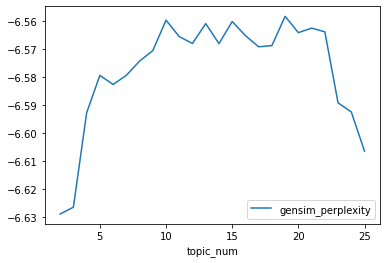

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-6.628898,756.648085
1,3,-6.626455,754.801303
2,4,-6.592698,729.747057
3,5,-6.579265,720.009838
4,6,-6.582552,722.380419
5,7,-6.579264,720.008939
6,8,-6.574174,716.353319
7,9,-6.570424,713.672113
8,10,-6.559523,705.934841
9,11,-6.565417,710.108128


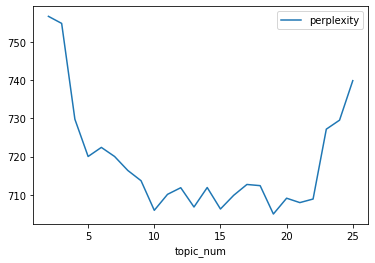

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_us_brief_paragraph_2017.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

12

In [23]:
topics_us = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_us.append(c.index(max(c)))

In [24]:
topics_us

[12,
 18,
 9,
 5,
 5,
 18,
 5,
 18,
 2,
 9,
 9,
 18,
 8,
 15,
 1,
 3,
 3,
 15,
 9,
 11,
 18,
 18,
 18,
 17,
 3,
 1,
 13,
 8,
 6,
 3,
 4,
 18,
 15,
 3,
 6,
 18,
 1,
 8,
 10,
 16,
 18,
 9,
 17,
 18,
 18,
 4,
 3,
 8,
 4,
 6,
 5,
 16,
 18,
 15,
 18,
 18,
 18,
 14,
 9,
 18,
 11,
 12,
 3,
 12,
 12,
 6,
 18,
 0,
 0,
 18,
 5,
 13,
 2,
 18,
 0,
 12,
 5,
 2,
 18,
 18,
 3,
 18,
 18,
 3,
 1,
 18,
 18,
 8,
 18,
 16,
 1,
 17,
 15,
 8,
 2,
 18,
 18,
 13,
 9,
 15,
 12,
 18,
 17,
 18,
 3,
 5,
 5,
 5,
 8,
 2,
 2,
 8,
 12,
 2,
 10,
 8,
 9,
 17,
 16,
 5,
 4,
 6,
 12,
 4,
 14,
 5,
 6,
 18,
 18,
 18,
 14,
 5,
 16,
 1,
 7,
 7,
 8,
 17,
 0,
 18,
 6,
 12,
 4,
 3,
 3,
 12,
 5,
 18,
 5,
 4,
 10,
 18,
 14,
 12,
 1,
 13,
 6,
 0,
 2,
 3,
 0,
 7,
 7,
 5,
 3,
 18,
 14,
 2,
 5,
 15,
 12,
 7,
 7,
 18,
 10,
 5,
 5,
 0,
 16,
 4,
 13,
 1,
 16,
 7,
 6,
 18,
 18,
 12,
 7,
 7,
 14,
 9,
 5,
 8,
 6,
 14,
 4,
 9,
 17,
 18,
 6,
 18,
 17,
 2,
 0,
 9,
 17,
 3,
 7,
 18,
 6,
 7,
 7,
 18,
 10,
 3,
 3,
 4,
 4,
 18,
 11,
 12,
 4,
 12,


In [25]:
print(len(topics_us))
print(len(us_desc))

5127
5127


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2017 = db.rm_patent_us_2017
    db_rm_us_2017 = db.rm_patent_us_2017
    # db_rm_de_2017 = db.rm_patent_de_2017
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_us_desc = db_rm_us_2017.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_us_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_us

,id,patentNumber,company,brief
0,62009ca97b73c16636b310a8,US9993183B2,[],An apparatus comprising a system with an array...
1,6200a82a7b73c16636b310e6,US20190124021A1,[Nim Sar],A messaging platform operates as a mobile devi...
2,6200b0a07b73c16636b310f0,US9800675B2,[PTC Inc],This technology generates a plurality of insta...
3,6200b43f7b73c16636b31124,US20180103418A1,[IoT Holdings Inc],Disclosed herein are embodiments for Machine T...
4,6200b46d7b73c16636b31128,US20170265163A1,[IoT Holdings Inc],A method and apparatus for triggering a machin...
...,...,...,...,...
5122,6208fb81e0ec9a30af2ab3e9,US20200213061A1,[Alcatel Lucent SAS],The objective of the present disclosure is to ...
5123,6208fb83e0ec9a30af2ab3ed,US10750561B2,[Motorola Mobility LLC],The present invention provides a user equipmen...
5124,6208fbb9e0ec9a30af2ab3fd,US20210176594A1,[Everynet Bv],The invention relates to the field of geolocat...
5125,6208fbbce0ec9a30af2ab3ff,US20210289531A1,"[Nokia Solutions and Networks Oy, Alcatel Luce...",Embodiments of the present disclosure provide ...


In [30]:
print(len(df_us))
print(len(us_desc))

5127
5127


In [31]:
df_us["topic"]=topics_us

In [32]:
df_us

,id,patentNumber,company,brief,topic
0,62009ca97b73c16636b310a8,US9993183B2,[],An apparatus comprising a system with an array...,12
1,6200a82a7b73c16636b310e6,US20190124021A1,[Nim Sar],A messaging platform operates as a mobile devi...,18
2,6200b0a07b73c16636b310f0,US9800675B2,[PTC Inc],This technology generates a plurality of insta...,9
3,6200b43f7b73c16636b31124,US20180103418A1,[IoT Holdings Inc],Disclosed herein are embodiments for Machine T...,5
4,6200b46d7b73c16636b31128,US20170265163A1,[IoT Holdings Inc],A method and apparatus for triggering a machin...,5
...,...,...,...,...,...
5122,6208fb81e0ec9a30af2ab3e9,US20200213061A1,[Alcatel Lucent SAS],The objective of the present disclosure is to ...,5
5123,6208fb83e0ec9a30af2ab3ed,US10750561B2,[Motorola Mobility LLC],The present invention provides a user equipmen...,16
5124,6208fbb9e0ec9a30af2ab3fd,US20210176594A1,[Everynet Bv],The invention relates to the field of geolocat...,14
5125,6208fbbce0ec9a30af2ab3ff,US20210289531A1,"[Nokia Solutions and Networks Oy, Alcatel Luce...",Embodiments of the present disclosure provide ...,1


In [33]:
df_us2 = df_us.explode('company')
df_us2

,id,patentNumber,company,brief,topic
0,62009ca97b73c16636b310a8,US9993183B2,NaN,An apparatus comprising a system with an array...,12
1,6200a82a7b73c16636b310e6,US20190124021A1,Nim Sar,A messaging platform operates as a mobile devi...,18
2,6200b0a07b73c16636b310f0,US9800675B2,PTC Inc,This technology generates a plurality of insta...,9
3,6200b43f7b73c16636b31124,US20180103418A1,IoT Holdings Inc,Disclosed herein are embodiments for Machine T...,5
4,6200b46d7b73c16636b31128,US20170265163A1,IoT Holdings Inc,A method and apparatus for triggering a machin...,5
...,...,...,...,...,...
5123,6208fb83e0ec9a30af2ab3ed,US10750561B2,Motorola Mobility LLC,The present invention provides a user equipmen...,16
5124,6208fbb9e0ec9a30af2ab3fd,US20210176594A1,Everynet Bv,The invention relates to the field of geolocat...,14
5125,6208fbbce0ec9a30af2ab3ff,US20210289531A1,Nokia Solutions and Networks Oy,Embodiments of the present disclosure provide ...,1
5125,6208fbbce0ec9a30af2ab3ff,US20210289531A1,Alcatel Lucent SAS,Embodiments of the present disclosure provide ...,1


In [34]:
# 排名前16的公司
c_ls = list(df_us2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Samsung Electronics Co Ltd',
 'Qualcomm Inc',
 'Telefonaktiebolaget LM Ericsson AB',
 'Intel Corp',
 'International Business Machines Corp',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'LG Electronics Inc',
 'NTT Docomo Inc',
 'Nokia Technologies Oy',
 'NEC Corp',
 'Amazon Technologies Inc',
 'Apple Inc',
 'Sharp Corp',
 'Sony Corp',
 'AT&T Intellectual Property I LP']

### 轉成company-topic 的總數表格

In [35]:
df_us_count = df_us2.groupby(["company","topic"],as_index=False).size()
df_us_count

,company,topic,size
0,7Signal Inc,18,1
1,A10 Networks Inc,3,1
2,A9 com Inc,18,1
3,ABB Schweiz AG,5,1
4,ABB Schweiz AG,7,1
...,...,...,...
2131,eLumigen LLC,6,1
2132,iRobot Corp,16,1
2133,nChain Holdings Ltd,17,1
2134,u-blox AG,16,1


In [36]:
# 轉成company-topic 的總數表格
table_us = df_us_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_us = table_us.droplevel(level=0, axis=1)
table_us = table_us.rename(columns={'':'company'})

In [37]:
table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,7Signal Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,A10 Networks Inc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A9 com Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,ABB Schweiz AG,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,ABL IP Holding LLC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,eLumigen LLC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1105,iRobot Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1106,nChain Holdings Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1107,u-blox AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [38]:
final_table_us = table_us[table_us.company.isin(c_ls)]
final_table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
12,AT&T Intellectual Property I LP,5.0,1.0,1.0,4.0,1.0,7.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0,4.0,2.0,20.0
51,Amazon Technologies Inc,3.0,0.0,1.0,5.0,2.0,4.0,2.0,2.0,4.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,3.0,28.0
67,Apple Inc,1.0,12.0,1.0,2.0,2.0,8.0,0.0,0.0,1.0,0.0,2.0,1.0,3.0,4.0,3.0,4.0,8.0,2.0,2.0
186,Cisco Technology Inc,4.0,1.0,3.0,26.0,2.0,4.0,3.0,5.0,3.0,3.0,1.0,3.0,7.0,3.0,16.0,3.0,2.0,3.0,38.0
437,Intel Corp,13.0,16.0,10.0,22.0,20.0,24.0,32.0,15.0,7.0,22.0,4.0,3.0,27.0,16.0,15.0,17.0,12.0,12.0,35.0
445,International Business Machines Corp,14.0,4.0,4.0,13.0,5.0,8.0,11.0,3.0,12.0,12.0,6.0,6.0,31.0,13.0,5.0,32.0,2.0,13.0,53.0
526,LG Electronics Inc,4.0,22.0,8.0,0.0,1.0,12.0,1.0,5.0,3.0,1.0,1.0,10.0,3.0,3.0,5.0,7.0,13.0,2.0,2.0
589,Microsoft Technology Licensing LLC,2.0,2.0,1.0,3.0,4.0,6.0,0.0,1.0,3.0,17.0,1.0,6.0,10.0,1.0,1.0,7.0,3.0,6.0,34.0
606,NEC Corp,1.0,9.0,7.0,4.0,5.0,2.0,2.0,0.0,12.0,2.0,0.0,0.0,3.0,4.0,0.0,4.0,5.0,0.0,4.0
610,NTT Docomo Inc,0.0,68.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,14.0,0.0,0.0


In [39]:
final_table_us.shape

(16, 20)

In [40]:
table_us.to_csv('company_lda_brief_us_2017.csv',index=0)